# Gibbs sampling

If you find this ipython notebook is unclear or contains bugs, please contact qiuwch@gmail.com  
If there's an error says "something is undefined", please run cell which contains the definition or use "menu -> cell -> run all above"

# Foreground/background classification.

Here we consider a model for foreground/background classification so that it can include spatial context. Intuitively neighboring pixels in the image are likely to belong to the same class, i.e. are likely to be either all background or all foreground. This is a form of prior knowledge, or natural statistic, which can be learnt by analyzing natural images.

For pixel i, the foreground label is $ S_i = 1 $, and background label is $ S_i $ = -1.

The prior term encourages neighbouring pixels to have the same intensity:  
$ E_P[S] = \gamma \sum_{i} \sum_{j \in N(i)} { - S_i S_j} $ 

The data term is defined as:

$ E_d[S, I] = \eta \sum_{i} (I_i - S_i)^2 $


These two terms are combined to get the energy.

$ E(S) = E_p[S] + E_d[S, I] $

Then the posterior of the labeling S given the image I is

$ P(S|I) = \frac{1}{Z} exp( - \frac{E[S]}{T} ) $

The block of code below initializes the ipython notebook

In [8]:
# Initiialization code
%matplotlib inline
import numpy as np
# from pylab import imshow, show, get_cmap, imread, figure, subplots, title, subplot
import matplotlib.pyplot as plt
from numpy import random

The block of code below loads an image and convert it to range (-1, 1).

original range: 0.0 0.846330682811
remaped range: -1.0 1.0


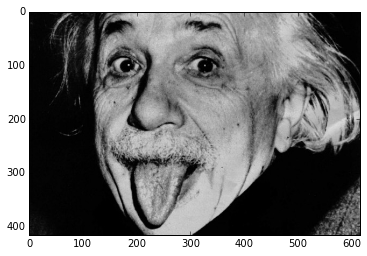

In [11]:
im = plt.imread('../data/gibbs/gibbs_demo.jpg')
plt.imshow(im)

def myimshow(state):
    plt.imshow(state, interpolation='nearest')

# Preprocess image to range (-1, 1)
def preproc_data(im, scale=0.1, debug=False):
    import skimage.color
    import skimage.transform
    
    tinyim = skimage.transform.rescale(im, scale)
    grayim = skimage.color.rgb2gray(tinyim)

    # Linear map the data to -1, 1
    scale = grayim.max() - grayim.min()
    data = 2 * (grayim - grayim.min()) / scale - 1
    if debug:
        print 'original range:', grayim.min(), grayim.max()
        print 'remaped range:', data.min(), data.max()

    return [data, tinyim]

[data, im] = preproc_data(im, debug=True) # data is normalized image

The block of code below defines neighborhood structure for gibbs sampler.

In [12]:
def getneighor(y, x, h, w): # get 4-side neighbor
    n = []
    if (x != 0): n.append((y, x-1))
    if (x != w-1): n.append((y, x+1))
    if (y != 0): n.append((y-1, x))
    if (y != h-1): n.append((y+1, x))
    return n

def poslist(h,w):
    '''Get point list of a grid'''
    pos = []
    for x in range(w):
        for y in range(h):
            pos.append((y, x))
    return pos

Define a utility function to compute energy.

In [13]:
def energy_prior(state, gamma):
    total = 0
    (h, w) = state.shape
    pos = poslist(h, w)
    for p in pos:
        neighbor = getneighor(p[0], p[1], h, w) # compute neighbor
        
        for n in neighbor:
            total += state[p[0]][p[1]] * state[n[0]][n[1]]
    E = - gamma * total / 2 # gamma is a global variable
    return E/2
        
def energy_data(state, data, eta):
    E = eta * sum((data - state)**2)
    return E

def energy(state, data, gamma, eta):
    return energy_prior(state, gamma) + energy_data(state, data, eta)

Define the gibbs sampler.

In [14]:
def gibbs_sampler(state, data, gamma, eta, debug=False): # 0/1 state
    (h, w) = state.shape
    new_state = state.copy()
    pos = poslist(h, w)
    for p in pos:
        neighbor_pos = getneighor(p[0], p[1], h, w)
        neighbor_value = [new_state[n[0]][n[1]] for n in neighbor_pos]

        tmp1 = -gamma * -1 * sum(neighbor_value) # x_i = -1
        tmp2 = -gamma * 1 * sum(neighbor_value) # x_i = 1
        
        # add data term
        v = data[p[0]][p[1]]
        tmp1 += eta * (v - (-1))**2 # x_i = -1
        tmp2 += eta * (v - 1)**2 #  x_i = 1
        
        tmp1 = np.exp(-tmp1)
        tmp2 = np.exp(-tmp2)

        p1 = tmp1 / (tmp1 + tmp2)
        prob = random.uniform() # roll a dice
        
        if (debug): print p1
        if (prob > p1):
            new_state[p[0]][p[1]] = 1
        else:
            new_state[p[0]][p[1]] = -1
    return new_state

# Animation: sample with data term included
Run this demo below

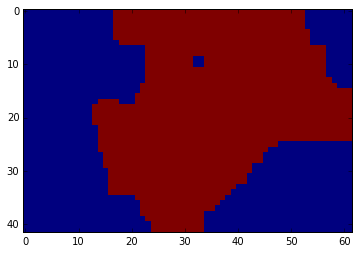

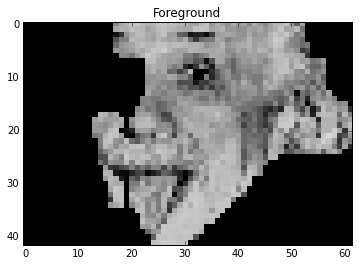

In [22]:
from IPython.display import display, clear_output
import time

random_seed = 1 # Change this in your experiment
random.seed(random_seed)

(h, w) = data.shape
mat = random.random((h,w))
mat[mat>0.5] = 1
mat[mat<=0.5] = -1
random_state = mat
init_state = random_state

new_state = random_state.copy()
E = [energy(init_state, data, gamma=20, eta=1)]

f, ax = plt.subplots() # prepare animation
for i in range(60):
    clear_output(wait=True)
    new_state = gibbs_sampler(new_state, data, gamma=20, eta=1)

    # time.sleep(1)
    myimshow(new_state)
    display(f)

plt.title("Foreground")
mask = (new_state==1)
fg = im.copy()
for i in range(3): 
    fg[:,:,i] = fg[:,:,i] * mask
plt.imshow(fg, cmap='gray', interpolation='nearest')


# Exercise 1. Gibbs sampler
Set random_seed to a different value
1. Try different values of $ \gamma $, $ \eta $, including special case that only contains prior term. What happens when the parameters change?
2. Run with different images, plot your result. Find two or three images from web or your image collection.
3. When does the sampler converge for the Einstein image with $ \gamma = 20 $ and $ \eta = 1 $ and how do you know it?

Run with different images and plot results.

In [23]:
def runGibbsSampler(data, gamma, eta, showAnimation=True):
    (h, w) = data.shape
    mat = random.random((h,w))
    mat[mat>0.5] = 1
    mat[mat<=0.5] = -1
    random_state = mat
    init_state = random_state

    new_state = random_state.copy()
    E = [energy(init_state, data, gamma=gamma, eta=eta)]
    
    if showAnimation:
        f, ax = subplots() # prepare animation
        
    for i in range(60):
        clear_output(wait=True)
        new_state = gibbs_sampler(new_state, data, gamma, eta)
        E.append(energy(new_state, data, gamma=gamma, eta=eta))
        # time.sleep(1)
        if showAnimation:
            myimshow(new_state)
            display(f)
        else:
            print 'iteration %d' % i

    return new_state

def fgBgSegmentation(filename):
    im = plt.imread(filename)
    [data, im] = preproc_data(im, scale=0.5)
    state = runGibbsSampler(data, eta=1, gamma=1, showAnimation=False)

    mask = (state==1)
    fg = im.copy()
    for i in range(3): 
        fg[:,:,i] = fg[:,:,i] * mask

    plt.subplot(1,3,1)
    plt.imshow(im, interpolation='nearest'); plt.axis('off');
    plt.subplot(1,3,2)
    plt.imshow(state); plt.axis('off');
    plt.subplot(1,3,3)
    plt.imshow(fg, interpolation='nearest'); plt.axis('off');

iteration 59


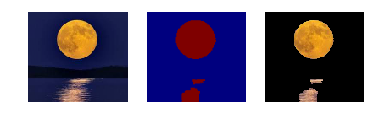

In [21]:
fgBgSegmentation('../data/gibbs/moon.jpg')

iteration 59


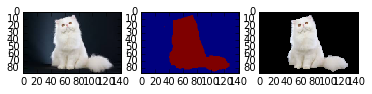

In [20]:
fgBgSegmentation('../data/gibbs/cat3.jpg')

iteration 59


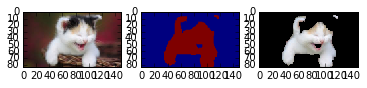

In [21]:
fgBgSegmentation('../data/gibbs/cat4.jpg')